### IMPORTING LIBRARIES

In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import optimizers
from keras import backend as K
from tensorflow import keras
from keras.callbacks import TensorBoard
import tensorflow as tf
from SSIM_PIL import compare_ssim as ssim
from PIL import Image
import os, glob
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity
import argparse
import imutils
import cv2
from scipy import signal

2023-08-14 16:16:33.362690: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### AUTOENCODER ARCHITECTURE

In [2]:
#input_img = Input(shape=(128, 128, 1))  
input_img = Input(shape=(256, 256, 1))
# Encode-----------------------------------------------------------
x = Conv2D(32, (4, 4), strides=2 , activation='relu', padding='same')(input_img)
x = Conv2D(32, (4, 4), strides=2, activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
x = Conv2D(64, (4, 4), strides=2, activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x = Conv2D(128, (4, 4), strides=2, activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
encoded = Conv2D(100, (8, 8), strides=1, padding='same')(x)
# Decode---------------------------------------------------------------------
x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(encoded)
x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (4, 4), strides=2, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (4, 4), strides=2, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (4, 4), strides=2, activation='relu', padding='same')(x)
x = UpSampling2D((4, 4))(x)
x = Conv2D(32, (4, 4), strides=2, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (8, 8), activation='sigmoid', padding='same')(x)

2023-08-14 16:14:43.388742: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


### SSIM LOSS FUNCTION

In [2]:
#ssim loss function
def ssim_loss(y_true,y_pred):
    return 1-tf.reduce_mean(tf.image.ssim(y_true,y_pred,1.0))

### TRAINING AUTOENCODER MODEL

In [4]:
# MODEL SUMMARY---------------------------------------------------------------------
autoencoder = Model(input_img, decoded)
adam = keras.optimizers.legacy.Adam(learning_rate=0.0002, decay=0.00001)
autoencoder.compile(optimizer='adam', loss=ssim_loss)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      544       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        16416     
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        32832     
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 128)       131200

In [5]:

# TRAINING MODEL WITH OUR Own Image Directory---------------------------------------
img_dir = (r"/home/pratyush-g/Documents/Defect_Detection_Autoencoders/dataset/steel_sheet/train/good/")
img_files = glob.glob(img_dir + "*.jpg")
# Setting Image Properties
width = 256
height = 256
pixels = width * height * 1 # gray scale 

# Load Image 
x = []

for i, f in enumerate(img_files):
    img = Image.open(f)
#   img = img.convert("RGB")
    img = img.convert("L") # gray scale
    img = img.resize((width,height), 1)
    data = np.asarray(img)
    
    x.append(data)
    if i % 100 == 0:
        print(i, "\n", data)

x = np.array(x)
(x_train, x_test) = train_test_split(x, shuffle=False, train_size=0.8, random_state=1)

img_list = (x_train, x_test)
np.save("./obj.npy", img_list)
print("OK", len(x)) 

# change to float32
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 256, 256, 1))  
x_test = np.reshape(x_test, (len(x_test), 256, 256, 1)) 


0 
 [[140 139 138 ... 168 168 168]
 [154 153 152 ... 156 156 156]
 [137 136 135 ... 123 123 123]
 ...
 [108 108 108 ... 227 227 227]
 [103 103 103 ... 228 228 228]
 [ 84  84  84 ... 193 193 193]]
100 
 [[ 60  60  60 ... 189 185 184]
 [ 60  60  60 ... 190 186 185]
 [ 61  61  61 ... 191 187 186]
 ...
 [127 128 132 ...  26  26  27]
 [128 129 132 ...  25  26  26]
 [130 131 132 ...  26  25  25]]
200 
 [[64 63 61 ... 59 53 48]
 [64 63 61 ... 59 53 48]
 [64 63 61 ... 59 53 48]
 ...
 [69 66 29 ... 72 72 74]
 [61 63 34 ... 72 72 74]
 [66 67 34 ... 72 72 74]]
OK 209


/home/pratyush-g/miniconda3/envs/PratGaur/lib/python3.11/site-packages/numpy/lib/npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [6]:
#fit model
history = autoencoder.fit(x_train, x_train,
                epochs= 100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/100
2/2 [==============================] - 19s 5s/step - loss: 0.4364 - val_loss: 0.4191
Epoch 2/100
2/2 [==============================] - 19s 7s/step - loss: 0.4426 - val_loss: 0.4165
Epoch 3/100
2/2 [==============================] - 18s 6s/step - loss: 0.4365 - val_loss: 0.4165
Epoch 4/100
2/2 [==============================] - 18s 6s/step - loss: 0.4365 - val_loss: 0.4165
Epoch 5/100


KeyboardInterrupt: 

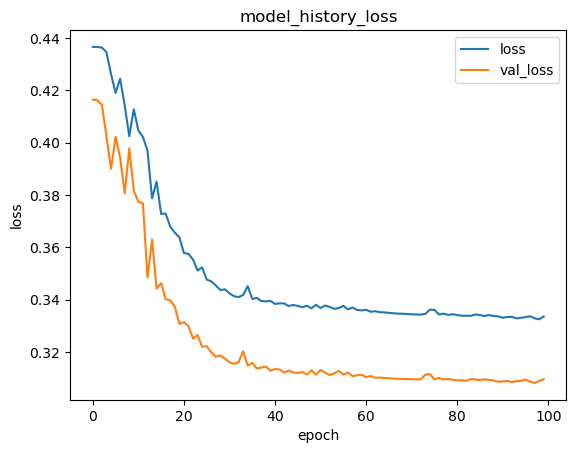

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_history_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['loss','val_loss'],loc='upper right')
plt.show()

### SAVING MODEL

In [44]:
autoencoder.save('C:\\Users\\ANUPAM BARLA\saved_model_128x128_epoch50_batchsize128_zdim100_steel_sheet/')

INFO:tensorflow:Assets written to: C:\Users\ANUPAM BARLA\saved_model_128x128_epoch250_batchsize128_zdim100_horse_good_3/assets


### LOADING MODEL

In [4]:
autoencoder = keras.models.load_model('/home/pratyush-g/Documents/Defect_Detection_Autoencoders/saved models/saved_model_128x128_epoch50_batchsize128_zdim100_steel_sheet/',custom_objects ={'ssim_loss':ssim_loss})

2023-08-14 16:17:47.112650: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


### SSIM CALCULATION FUNCTION

In [5]:

def cal_ssim(img1, img2):
    
    K = [0.01, 0.03]
    L = 255
    kernelX = cv2.getGaussianKernel(11, 1.5)
    window = kernelX * kernelX.T
     
    M,N = np.shape(img1)

    C1 = (K[0]*L)**2
    C2 = (K[1]*L)**2
    img1 = np.float64(img1)
    img2 = np.float64(img2)
 
    mu1 = signal.convolve2d(img1, window, 'valid')
    mu2 = signal.convolve2d(img2, window, 'valid')
    
    mu1_sq = mu1*mu1
    mu2_sq = mu2*mu2
    mu1_mu2 = mu1*mu2
    
    
    sigma1_sq = signal.convolve2d(img1*img1, window, 'valid') - mu1_sq
    sigma2_sq = signal.convolve2d(img2*img2, window, 'valid') - mu2_sq
    sigma12 = signal.convolve2d(img1*img2, window, 'valid') - mu1_mu2
   
    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))
    mssim = np.mean(ssim_map)
    return mssim,ssim_map


###  DEFECT SEGMENTATION AND MASK FUNCTION

In [6]:
def ssim_seg(ori_img, re_img):
   
    # convert the images to grayscale
    if len(ori_img.shape) == 3:
        ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2GRAY)
    if len(re_img.shape) == 3:
        re_img = cv2.cvtColor(re_img, cv2.COLOR_BGR2GRAY)
    (s, s_map) = cal_ssim(ori_img, re_img)
    #(s, s_map) = structural_similarity(ori_img, re_img, full=True,multichannel=True)
    s      = np.clip(s_map, 0, 1)
    return s_map

def seg_mask(s_map, threshold=64):
    s_map = (s_map * 255).astype("uint8")
    mask = s_map.copy()
    mask[s_map > threshold] = 255
    mask[s_map <= threshold] = 0
    return mask

### CHECKING FOR DEFECT FOR A SINGLE IMAGE FILE

1/1 [==============================] - 0s 26ms/step
ssim value is : 0.10380834375090787
/home/pratyush-g/Documents/Defect_Detection_Autoencoders/dataset/steel_sheet/test/bad/004.jpg is Defected
Inference time is 0.1613282749999998 seconds


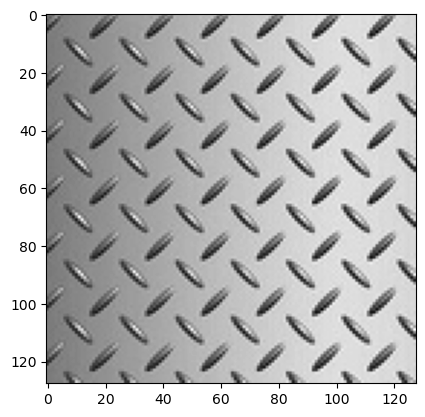

In [9]:
import numpy as np
import time
start = time.process_time()

width = 128
height = 128

file_name = r'/home/pratyush-g/Documents/Defect_Detection_Autoencoders/dataset/steel_sheet/test/bad/004.jpg'
img = Image.open(file_name)
# img = img.convert("RGB")
img = img.convert("L") # gray scale
img = img.resize((width,height), 1)
data = np.array(img)

plt.imshow(img)
plt.gray()

data = data.astype('float32') / 255.
test_img = np.resize(data, (1,128, 128, 1))  # adapt this if using `channels_first` image data format
#print (test_img.shape)
decoded_imgs = autoencoder.predict(test_img)
npDecoded = decoded_imgs.reshape((128,128))
formatted2 = (npDecoded * 255 / np.max(npDecoded)).astype('uint8')
decoded = Image.fromarray(formatted2)
npImg = data
npImg = npImg.reshape((128, 128))
formatted = (npImg * 255 / np.max(npImg)).astype('uint8')
img = Image.fromarray(formatted)
#value,dd = cal_ssim(img,decoded)  
value,dd = structural_similarity(npImg, npDecoded, data_range=npImg.max() - npDecoded.min(), full=True)   
if value<0.95:
    ok = 'Defected'
else:
    ok = 'Not Defected'

print(f'ssim value is : {value}')
print(f'{file_name} is {ok}')
end = time.process_time() 
# your code here    
print(f"Inference time is {end-start} seconds")

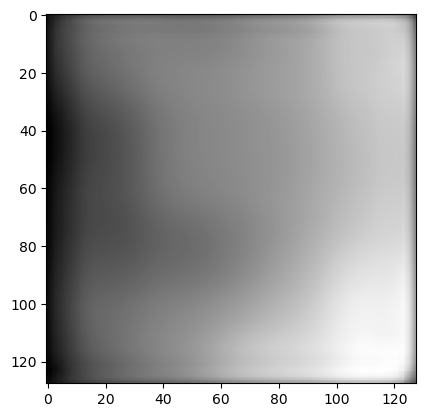

In [11]:
#plotting decoded image
plt.imshow(decoded_imgs.reshape(128, 128))
plt.gray()

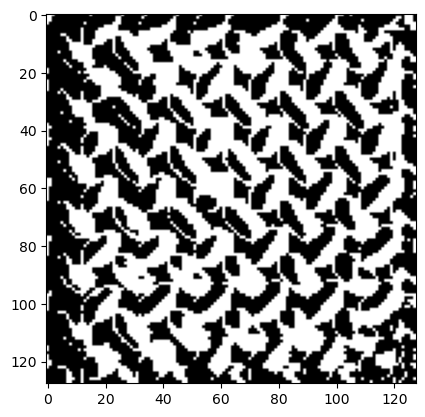

In [12]:
# plotting residual map 
(score, diff) = structural_similarity(npImg, npDecoded, data_range=npImg.max() - npDecoded.min(), full=True)
diff = (diff * 255).astype("uint8")
s_map = ssim_seg(npImg, npDecoded)
mask= seg_mask(diff, threshold = 230)
plt.imshow(mask)
plt.gray()

Text(0.5, 1.0, 'Defect SSIM_Map')

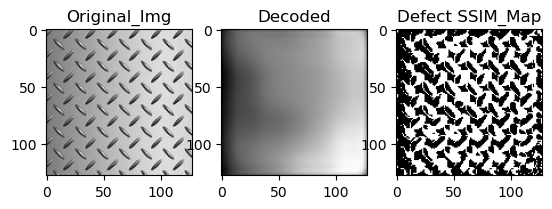

In [14]:
plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title("Original_Img")
plt.subplot(1,3,2)
plt.imshow(decoded, cmap='gray')
plt.title("Decoded")
plt.subplot(1,3,3)
plt.imshow(mask, cmap='gray')
plt.title("Defect SSIM_Map")

Number of Contours found = 479


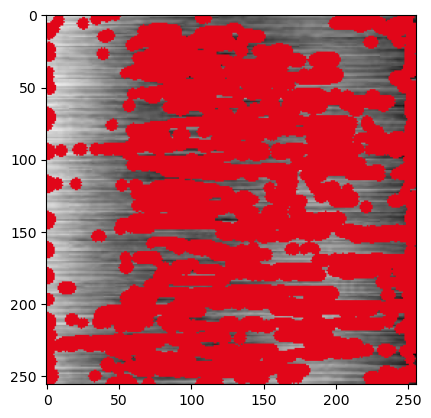

In [16]:
#-----------------------------
# Find Canny edges
edged = cv2.Canny(mask, 30, 200)
e = edged.copy()
# Finding Contours  Use a copy of the image e.g. edged.copy() since findContours alters the image
contours, hierarchy = cv2.findContours(e,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
print("Number of Contours found = " + str(len(contours)))
# Draw all contours (-1 signifies drawing all contours)
np=cv2.cvtColor(npImg,cv2.COLOR_GRAY2RGB)
img_=cv2.cvtColor(np,cv2.COLOR_RGB2HSV)
cv2.drawContours(img_, contours, -1, (1,200,287), 6)
im=cv2.cvtColor(img_,cv2.COLOR_HSV2RGB)
im = (im * 255).astype("uint8")
plt.imshow(im)
#-----------------------------
#plotting segmented defect on original image

### CHECKING FOR DEFECT FOR A FOLDER CONTAINING TEST IMAGES

(4, 128, 128, 1)


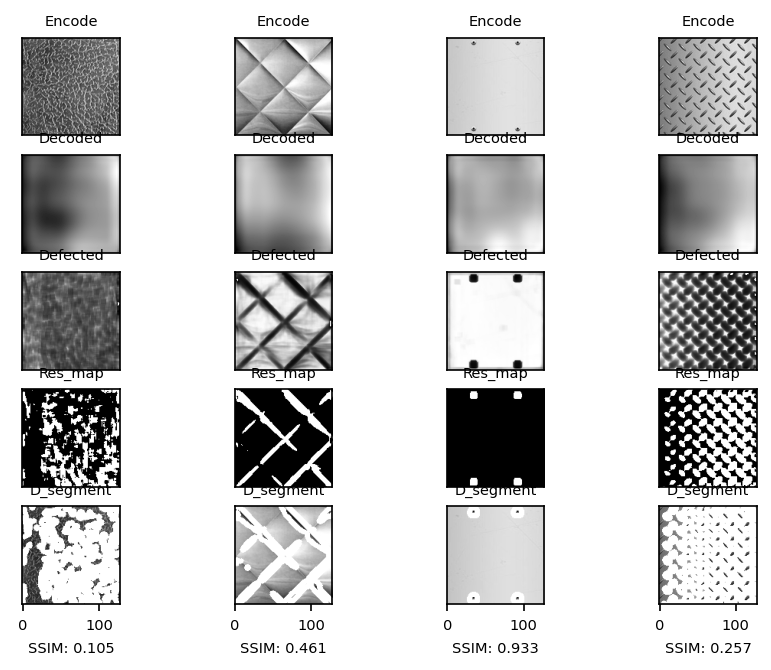

In [96]:
import numpy as np

s_values=[]

img_dir = (r"C:\\Users\\ANUPAM BARLA\steel_sheet\test\bad/")
img_files = glob.glob(img_dir + "*.jpg")
# Setting Image Properties
width = 128
height = 128
 
# Load Image
x = []

for i, f in enumerate(img_files):
    img = Image.open(f)
    #img = img.convert("RGB")
    img = img.convert("L") # gray sclae
    img = img.resize((width,height), 1)
    data = np.asarray(img)
    x.append(data)

x_test = np.array(x)
x_test = x_test.astype('float32') / 255.
x_test = np.reshape(x_test, (len(x_test), 128, 128, 1))  # adapt this if using `channels_first` image data format
print (x_test.shape) 

decoded_imgs = autoencoder.predict(x_test)

defected = 0
non_defected = 0

n = 4  # number of images to be displayed
plt.figure(figsize=(7, 5), dpi=150)
for i in range(n):
    # display original
    ax = plt.subplot(5, n, i + 1)
    plt.imshow(x_test[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # SSIM Encode
    ax.set_title("Encode",fontsize=7)    
    npImg = x_test[i]
    npImg = npImg.reshape((128,128))
    formatted = (npImg * 255 / np.max(npImg)).astype('uint8')
    img = Image.fromarray(formatted)

    # display reconstruction
    ax = plt.subplot(5, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # SSIM Decoded    
    npDecoded = decoded_imgs[i]
    npDecoded = npDecoded.reshape((128,128))
    formatted2 = (npDecoded * 255 / np.max(npDecoded)).astype('uint8')
    decoded = Image.fromarray(formatted2)
    
    value,dd = cal_ssim(img,decoded)
    s_values.append(value)
    
    if value<0.95:
        ok = 'Defected'
        defected+=1
            
    else:
        ok = 'Not Defected'
        non_defected+=1

    label = 'SSIM: {:.3f}'
    ax.set_title("Decoded",fontsize=7)
    (score, diff) = structural_similarity(npImg, npDecoded, full=True)
    diff = (diff * 255).astype("uint8")
    ax = plt.subplot(5, n, i + 1 + 2*n)
    
    plt.imshow(diff)
    plt.gray()
    ax.set_title(ok,fontsize=7)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    s_map = ssim_seg(npImg, npDecoded)
    mask= seg_mask(diff, threshold = 180)
    ax = plt.subplot(5, n, i + 1 + 3*n)
    plt.imshow(mask)
    plt.gray()
    ax.set_title("Res_map",fontsize=7)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_xlabel(label.format(value))
    
    # Find Canny edges
    edged = cv2.Canny(mask, 30, 200)
    e = edged.copy() 
    contours, hierarchy = cv2.findContours(e,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    ax = plt.subplot(5, n, i + 1 + 4*n)
    cv2.drawContours(npImg, contours, -1, (1,255,0), 6)
    plt.imshow(npImg)
    plt.gray()    
    ax.set_title("D_segment",fontsize=7)
    ax.get_xaxis().set_visible(True)
    plt.xticks(fontsize=7)
    ax.get_yaxis().set_visible(False)
    ax.set_xlabel(label.format(value),fontsize=7)
    
    
plt.show()

In [97]:
print("Total number of images",n)
print("Defected images",defected)
print("Not defected images",non_defected)

Total number of images 4
Defected images 4
Not defected images 0


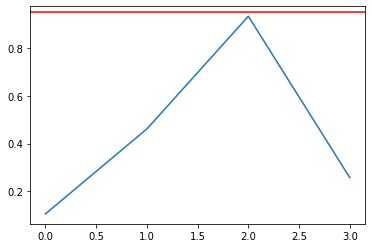

In [98]:
#plotting ssim values of test images with threshold red line 
plt.plot(s_values)
plt.axhline(y=0.95,color='r',linestyle='-')